In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
import time
import warnings

pd.set_option('display.max_columns', None)
plt.style.use(style = 'seaborn')

warnings.filterwarnings('ignore')

In [2]:
%%time

## DATA IMPORT ## 

data_path = "./data/"

train_tr = pd.read_csv(data_path + "train_transaction.csv")
train_id = pd.read_csv(data_path + "train_identity.csv") 
test_tr = pd.read_csv(data_path + "test_transaction.csv")
test_id = pd.read_csv(data_path + "test_identity.csv")

print('train_transaction shape is {}'.format(train_tr.shape))
print('train_identity shape is {}'.format(train_id.shape))

print('test_transaction shape is {}'.format(test_tr.shape))
print('test_identity shape is {}'.format(test_id.shape))

train_transaction shape is (590540, 394)
train_identity shape is (144233, 41)
test_transaction shape is (506691, 393)
test_identity shape is (141907, 41)
Wall time: 55 s


In [3]:
train_tr.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [4]:
train_id.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
test_tr.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,634.0,NaN,NaN,NaN,634.0,T,F,F,M0,NaN,F,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0

In [6]:
test_id.head()

,TransactionID,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [7]:
train = pd.merge(train_tr, train_id, how = 'left', on = 'TransactionID')
test = pd.merge(test_tr, test_id, how = 'left', on = 'TransactionID')
del train_tr, train_id, test_tr, test_id

In [8]:
print(train.shape)
print(test.shape)

(590540, 434)
(506691, 433)


In [9]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

In [10]:
test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,203.0,NaN,NaN,NaN,409.0,T,T,F,NaN,NaN,F,T,T,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,vis

In [11]:
def different_columns(traincols, testcols):
    
    for i in traincols:
        
        if i not in testcols:
            
            print(i)
            
different_columns(train.columns, test.columns)


isFraud
id_01
id_02
id_03
id_04
id_05
id_06
id_07
id_08
id_09
id_10
id_11
id_12
id_13
id_14
id_15
id_16
id_17
id_18
id_19
id_20
id_21
id_22
id_23
id_24
id_25
id_26
id_27
id_28
id_29
id_30
id_31
id_32
id_33
id_34
id_35
id_36
id_37
id_38


In [12]:
test = test.rename(columns = {"id-01": "id_01", "id-02": "id_02", "id-03": "id_03", 
                            "id-06": "id_06", "id-05": "id_05", "id-04": "id_04", 
                            "id-07": "id_07", "id-08": "id_08", "id-09": "id_09", 
                            "id-10": "id_10", "id-11": "id_11", "id-12": "id_12", 
                            "id-15": "id_15", "id-14": "id_14", "id-13": "id_13", 
                            "id-16": "id_16", "id-17": "id_17", "id-18": "id_18", 
                            "id-21": "id_21", "id-20": "id_20", "id-19": "id_19", 
                            "id-22": "id_22", "id-23": "id_23", "id-24": "id_24", 
                            "id-27": "id_27", "id-26": "id_26", "id-25": "id_25", 
                            "id-28": "id_28", "id-29": "id_29", "id-30": "id_30", 
                            "id-31": "id_31", "id-32": "id_32", "id-33": "id_33", 
                            "id-34": "id_34", "id-35": "id_35", "id-36": "id_36", 
                            "id-37": "id_37", "id-38": "id_38"})

different_columns(train.columns, test.columns)

isFraud


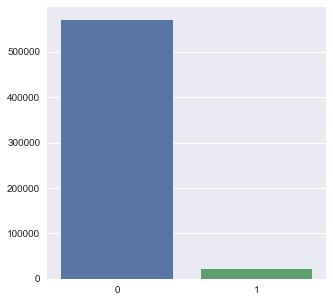

In [13]:
fig = plt.figure(figsize = (5, 5))

sns.barplot([0,1],train['isFraud'].value_counts().values)
plt.show()

In [14]:
fraud_ratio = train['isFraud'].sum()/len(train['isFraud'])
print(fraud_ratio)
del fraud_ratio

0.03499000914417313


In [15]:
tot_missing_value = train.isnull().sum().sum()
print(tot_missing_value)
del tot_missing_value

115523073


In [16]:
column_missing_value = train.isnull().sum()
print(column_missing_value[0 : 60])
print(column_missing_value[60 : 120])
print(column_missing_value[120 : 180])
print(column_missing_value[180 : 240])
print(column_missing_value[240 : 300])
print(column_missing_value[300 : 360])
print(column_missing_value[360 : 420])
print(column_missing_value[420 : 434])
del column_missing_value

TransactionID          0
isFraud                0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614


Text(0.5, 1.0, 'Train vs. Test TransactionDT Distribution')

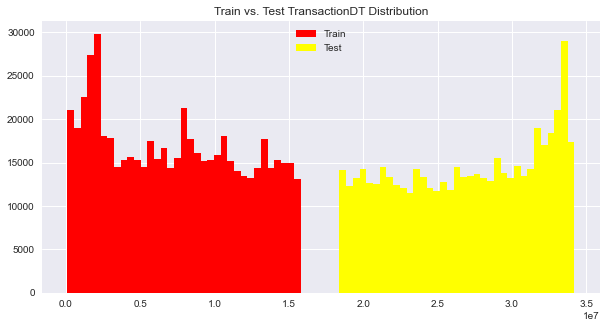

In [17]:
## plot dates of transaction. they don't overlap ##

fig = plt.figure(figsize = (10, 5))
plt.hist(train['TransactionDT'], label = 'Train', bins = 35, color = 'red')
plt.hist(test['TransactionDT'], label = 'Test', bins = 35, color = 'yellow')
plt.legend()
plt.title('Train vs. Test TransactionDT Distribution')

In [18]:
%%time

## ENCODING VARIABLES

from sklearn import preprocessing

variables_train = train.keys()
for k in variables_train:
    if train[k].dtype == object:
        le = preprocessing.LabelEncoder()
        train[k + '_encoded'] = le.fit_transform(train[k])  
        train = train.drop([k], axis=1)

train.head()

Wall time: 1min


,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_18,id_19,id_20,id_21,id_22,id_24,id_25,id_26,id_32,ProductCD_encoded,card4_encoded,card6_encoded,P_emaildomain_encoded,R_emaildomain_encoded,M1_encoded,M2_encoded,M3_encoded,M4_encoded,M5_encoded,M6_encoded,M7_encoded,M8_encoded,M9_encoded,id_12_encoded,id_15_encoded,id_16_encoded,id_23_encoded,id_27_encoded,id_28_encoded,id_29_encoded,id_30_encoded,id_31_encoded,id_33_encoded,id_34_encoded,id_35_encoded,id_36_encoded,id_37_encoded,id_38_encoded,DeviceType_encoded,DeviceInfo_encoded
0,2987000,0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [19]:
# UNBALANCED APPROACH - DT

X = train.copy()
y = train['isFraud'].copy()
X = X.drop(['isFraud'], axis=1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

from sklearn.impute import SimpleImputer

# Create our imputer to replace missing values with the mean e.g.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)

# Impute our data, then train
X_train_imp = imp.transform(X_train)

from sklearn.tree import DecisionTreeClassifier
clf_model = DecisionTreeClassifier(criterion="gini", random_state=17,max_depth=100, min_samples_leaf=50)   
clf_model.fit(X_train_imp,y_train)
y_pred = []
X_test_imp = imp.transform(X_test)
y_pred = clf_model.predict(X_test_imp)
y_train_pred = clf_model.predict(X_train_imp)

from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

print('-----------------------------------------------------')
print('Unbalanced DT - train precision score is {}'.format(precision_score(y_train, y_train_pred)))
print('Unbalanced DT - train accuracy score is {}'.format(accuracy_score(y_train, y_train_pred)))
print('Unbalanced DT - train recall score is {}'.format(recall_score(y_train, y_train_pred)))
print('Unbalanced DT - train auc score is {}'.format(roc_auc_score(y_train, y_train_pred)))
print('-----------------------------------------------------')
print('Unbalanced DT - test precision score is {}'.format(precision_score(y_test, y_pred)))
print('Unbalanced DT - test accuracy score is {}'.format(accuracy_score(y_test, y_pred)))
print('Unbalanced DT - test recall score is {}'.format(recall_score(y_test, y_pred)))
print('Unbalanced DT - test auc score is {}'.format(roc_auc_score(y_test, y_pred)))
print('-----------------------------------------------------')
print(' Train confusion matrix')
print(confusion_matrix(y_train, y_train_pred))
print('-----------------------------------------------------')
print(' Test confusion matrix')
print(confusion_matrix(y_test, y_pred))
print('-----------------------------------------------------')

-----------------------------------------------------
Unbalanced DT - train precision score is 0.790859707132735
Unbalanced DT - train accuracy score is 0.9752810986554679
Unbalanced DT - train recall score is 0.4033365454107444
Unbalanced DT - train auc score is 0.6997256539983161
-----------------------------------------------------
Unbalanced DT - test precision score is 0.7590529247910863
Unbalanced DT - test accuracy score is 0.9750821282216277
Unbalanced DT - test recall score is 0.4028085735402809
Unbalanced DT - test auc score is 0.6991289489767358
-----------------------------------------------------
 Train confusion matrix
[[454057   1771]
 [  9907   6697]]
-----------------------------------------------------
 Test confusion matrix
[[113530    519]
 [  2424   1635]]
-----------------------------------------------------


In [20]:
# UNBALANCED APPROACH - XGBOOST

xgmodel = xgb.XGBClassifier(n_estimators = 100,
                            max_depth = 12,
                            learning_rate = 0.02,
                            subsample = 0.8,
                            colsample_bytree = 0.4,
                            missing = -1,
                            random_state = 42,
                            tree_method = 'gpu_hist')
xgmodel.fit(X_train_imp,y_train)

y_pred = []
X_test_imp = imp.transform(X_test)
y_pred = xgmodel.predict(X_test_imp)
y_train_pred = xgmodel.predict(X_train_imp)

from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

print('-----------------------------------------------------')
print('Unbalanced XGB - train precision score is {}'.format(precision_score(y_train, y_train_pred)))
print('Unbalanced XGB - train accuracy score is {}'.format(accuracy_score(y_train, y_train_pred)))
print('Unbalanced XGB - train recall score is {}'.format(recall_score(y_train, y_train_pred)))
print('Unbalanced XGB - train auc score is {}'.format(roc_auc_score(y_train, y_train_pred)))
print('-----------------------------------------------------')
print('Unbalanced XGB - test precision score is {}'.format(precision_score(y_test, y_pred)))
print('Unbalanced XGB - test accuracy score is {}'.format(accuracy_score(y_test, y_pred)))
print('Unbalanced XGB - test recall score is {}'.format(recall_score(y_test, y_pred)))
print('Unbalanced XGB - test auc score is {}'.format(roc_auc_score(y_test, y_pred)))
print('-----------------------------------------------------')
print(' Train confusion matrix')
print(confusion_matrix(y_train, y_train_pred))
print('-----------------------------------------------------')
print(' Test confusion matrix')
print(confusion_matrix(y_test, y_pred))
print('-----------------------------------------------------')

[15:20:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
-----------------------------------------------------
Unbalanced XGB - train precision score is 0.9877965172082819
Unbalanced XGB - train accuracy score is 0.9799145697158533
Unbalanced XGB - train recall score is 0.4338713562996868
Unbalanced XGB - train auc score is 0.7168380536072527
-----------------------------------------------------
Unbalanced XGB - test precision score is 0.9456906729634003
Unbalanced XGB - test accuracy score is 0.9784180580485657
Unbalanced XGB - test recall score is 0.3946784922394678
Unbalanced XGB - test auc score is 0.696935910711269
-----------------------------------------------------
 Train confusion matrix
[[455739     89]
 [  9400   7204]]
------

In [21]:
## UNDERSAMPLING APPROACH - DT

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

ros = RandomUnderSampler(random_state=17)
X = train.copy()
y = train['isFraud'].copy()
X = X.drop(['isFraud'], axis=1)
X_resampled, y_resampled = ros.fit_resample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_resampled)))

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=17)

from sklearn.impute import SimpleImputer

# Create our imputer to replace missing values with the mean e.g.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)

# Impute our data, then train
X_train_imp = imp.transform(X_train)

from sklearn.tree import DecisionTreeClassifier
clf_model = DecisionTreeClassifier(criterion="gini", random_state=17,max_depth=100, min_samples_leaf=5)   
clf_model.fit(X_train_imp,y_train)
y_pred = []
X_test_imp = imp.transform(X_test)
y_pred = clf_model.predict(X_test_imp)
y_train_pred = clf_model.predict(X_train_imp)

from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

print('-----------------------------------------------------')
print('Undersampled DT - train precision score is {}'.format(precision_score(y_train, y_train_pred)))
print('Undersampled DT - train accuracy score is {}'.format(accuracy_score(y_train, y_train_pred)))
print('Undersampled DT - train recall score is {}'.format(recall_score(y_train, y_train_pred)))
print('Undersampled DT - train auc score is {}'.format(roc_auc_score(y_train, y_train_pred)))
print('-----------------------------------------------------')
print('Undersampled DT - test precision score is {}'.format(precision_score(y_test, y_pred)))
print('Undersampled DT - test accuracy score is {}'.format(accuracy_score(y_test, y_pred)))
print('Undersampled DT - test recall score is {}'.format(recall_score(y_test, y_pred)))
print('Undersampled DT - test auc score is {}'.format(roc_auc_score(y_test, y_pred)))
print('-----------------------------------------------------')
print(' Train confusion matrix')
print(confusion_matrix(y_train, y_train_pred))
print('-----------------------------------------------------')
print(' Test confusion matrix')
print(confusion_matrix(y_test, y_pred))
print('-----------------------------------------------------')

Resampled dataset shape Counter({0: 20663, 1: 20663})
-----------------------------------------------------
Undersampled DT - train precision score is 0.9375038943236339
Undersampled DT - train accuracy score is 0.9260133091349062
Undersampled DT - train recall score is 0.912487112620535
Undersampled DT - train auc score is 0.9259798425935335
-----------------------------------------------------
Undersampled DT - test precision score is 0.8154908732116428
Undersampled DT - test accuracy score is 0.8045003629324946
Undersampled DT - test recall score is 0.7920459990416866
Undersampled DT - test auc score is 0.8046251500584776
-----------------------------------------------------
 Train confusion matrix
[[15568  1003]
 [ 1443 15046]]
-----------------------------------------------------
 Test confusion matrix
[[3344  748]
 [ 868 3306]]
-----------------------------------------------------


In [22]:
## UNDERSAMPLING APPROACH - XGBOOST

xgmodel = xgb.XGBClassifier(n_estimators = 100,
                            max_depth = 12,
                            learning_rate = 0.02,
                            subsample = 0.8,
                            colsample_bytree = 0.4,
                            missing = -1,
                            random_state = 42,
                            tree_method = 'gpu_hist')
xgmodel.fit(X_train_imp,y_train)

y_pred = []
X_test_imp = imp.transform(X_test)
y_pred = xgmodel.predict(X_test_imp)
y_train_pred = xgmodel.predict(X_train_imp)

from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

print('-----------------------------------------------------')
print('Undersampled XGB - train precision score is {}'.format(precision_score(y_train, y_train_pred)))
print('Undersampled XGB - train accuracy score is {}'.format(accuracy_score(y_train, y_train_pred)))
print('Undersampled XGB - train recall score is {}'.format(recall_score(y_train, y_train_pred)))
print('Undersampled XGB - train auc score is {}'.format(roc_auc_score(y_train, y_train_pred)))
print('-----------------------------------------------------')
print('Undersampled XGB - test precision score is {}'.format(precision_score(y_test, y_pred)))
print('Undersampled XGB - test accuracy score is {}'.format(accuracy_score(y_test, y_pred)))
print('Undersampled XGB - test recall score is {}'.format(recall_score(y_test, y_pred)))
print('Undersampled XGB - test auc score is {}'.format(roc_auc_score(y_test, y_pred)))
print('-----------------------------------------------------')
print(' Train confusion matrix')
print(confusion_matrix(y_train, y_train_pred))
print('-----------------------------------------------------')
print(' Test confusion matrix')
print(confusion_matrix(y_test, y_pred))
print('-----------------------------------------------------')

[15:23:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
-----------------------------------------------------
Undersampled XGB - train precision score is 0.9526619283894328
Undersampled XGB - train accuracy score is 0.9096491228070176
Undersampled XGB - train recall score is 0.8616653526593486
Undersampled XGB - train auc score is 0.9095304012708366
-----------------------------------------------------
Undersampled XGB - test precision score is 0.8804966373512675
Undersampled XGB - test accuracy score is 0.8509557222356642
Undersampled XGB - test recall score is 0.8155246765692381
Undersampled XGB - test auc score is 0.8513107253813932
-----------------------------------------------------
 Train confusion matrix
[[15865   706]
 [ 2281 1

In [23]:
## OVERSAMPLING APPROACH - DT

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(random_state=17)
X = train.copy()
y = train['isFraud'].copy()
X = X.drop(['isFraud'], axis=1)
X_resampled, y_resampled = ros.fit_resample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_resampled)))

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=17)

from sklearn.impute import SimpleImputer

# Create our imputer to replace missing values with the mean e.g.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)

# Impute our data, then train
X_train_imp = imp.transform(X_train)

from sklearn.tree import DecisionTreeClassifier
clf_model = DecisionTreeClassifier(criterion="gini", random_state=17,max_depth=100, min_samples_leaf=50)   
clf_model.fit(X_train_imp,y_train)
y_pred = []
X_test_imp = imp.transform(X_test)
y_pred = clf_model.predict(X_test_imp)
y_train_pred = clf_model.predict(X_train_imp)

from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

print('-----------------------------------------------------')
print('Oversampled DT - train precision score is {}'.format(precision_score(y_train, y_train_pred)))
print('Oversampled DT - train accuracy score is {}'.format(accuracy_score(y_train, y_train_pred)))
print('Oversampled DT - train recall score is {}'.format(recall_score(y_train, y_train_pred)))
print('Oversampled DT - train auc score is {}'.format(roc_auc_score(y_train, y_train_pred)))
print('-----------------------------------------------------')
print('Oversampled DT - test precision score is {}'.format(precision_score(y_test, y_pred)))
print('Oversampled DT - test accuracy score is {}'.format(accuracy_score(y_test, y_pred)))
print('Oversampled DT - test recall score is {}'.format(recall_score(y_test, y_pred)))
print('Oversampled DT - test auc score is {}'.format(roc_auc_score(y_test, y_pred)))
print('-----------------------------------------------------')
print(' Train confusion matrix')
print(confusion_matrix(y_train, y_train_pred))
print('-----------------------------------------------------')
print(' Test confusion matrix')
print(confusion_matrix(y_test, y_pred))
print('-----------------------------------------------------')
## OVERSAMPLING IS BETTER THAN UNDERSAMPLING.

Resampled dataset shape Counter({0: 569877, 1: 569877})
-----------------------------------------------------
Oversampled DT - train precision score is 0.9263552471133726
Oversampled DT - train accuracy score is 0.9345834571722181
Oversampled DT - train recall score is 0.9443097415751028
Oversampled DT - train auc score is 0.9345781954520453
-----------------------------------------------------
Oversampled DT - test precision score is 0.9148340595279877
Oversampled DT - test accuracy score is 0.9262648551662419
Oversampled DT - test recall score is 0.9396899647407434
Oversampled DT - test auc score is 0.9262938276015882
-----------------------------------------------------
 Train confusion matrix
[[421411  34244]
 [ 25403 430745]]
-----------------------------------------------------
 Test confusion matrix
[[104273   9949]
 [  6859 106870]]
-----------------------------------------------------


In [24]:
## OVERSAMPLING APPROACH - XGBOOST

xgmodel = xgb.XGBClassifier(n_estimators = 100,
                            max_depth = 12,
                            learning_rate = 0.02,
                            subsample = 0.8,
                            colsample_bytree = 0.4,
                            missing = -1,
                            random_state = 42,
                            tree_method = 'gpu_hist')
xgmodel.fit(X_train_imp,y_train)

y_pred = []
X_test_imp = imp.transform(X_test)
y_pred = xgmodel.predict(X_test_imp)
y_train_pred = xgmodel.predict(X_train_imp)

from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

print('-----------------------------------------------------')
print('Oversampled XGB - train precision score is {}'.format(precision_score(y_train, y_train_pred)))
print('Oversampled XGB - train accuracy score is {}'.format(accuracy_score(y_train, y_train_pred)))
print('Oversampled XGB - train recall score is {}'.format(recall_score(y_train, y_train_pred)))
print('Oversampled XGB - train auc score is {}'.format(roc_auc_score(y_train, y_train_pred)))
print('-----------------------------------------------------')
print('Oversampled XGB - test precision score is {}'.format(precision_score(y_test, y_pred)))
print('Oversampled XGB - test accuracy score is {}'.format(accuracy_score(y_test, y_pred)))
print('Oversampled XGB - test recall score is {}'.format(recall_score(y_test, y_pred)))
print('Oversampled XGB - test auc score is {}'.format(roc_auc_score(y_test, y_pred)))
print('-----------------------------------------------------')
print(' Train confusion matrix')
print(confusion_matrix(y_train, y_train_pred))
print('-----------------------------------------------------')
print(' Test confusion matrix')
print(confusion_matrix(y_test, y_pred))
print('-----------------------------------------------------')

[15:31:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
-----------------------------------------------------
Oversampled XGB - train precision score is 0.9440181485880086
Oversampled XGB - train accuracy score is 0.9105848522104008
Oversampled XGB - train recall score is 0.8730390136534634
Oversampled XGB - train auc score is 0.9106051637382108
-----------------------------------------------------
Oversampled XGB - test precision score is 0.9391408791707649
Oversampled XGB - test accuracy score is 0.9084759443915579
Oversampled XGB - test recall score is 0.8731370187023538
Oversampled XGB - test auc score is 0.9083996802289411
-----------------------------------------------------
 Train confusion matrix
[[432039  23616]
 [ 57913 398235

In [25]:
#from sklearn.model_selection import RandomizedSearchCV

#clf_model = DecisionTreeClassifier(criterion="gini")
#distrib = dict(max_depth = [10,100,500], min_samples_leaf=[5,10,20,50])
#clf = RandomizedSearchCV(clf_model, distrib, random_state=17)
#search = clf.fit(X_train_imp,y_train)
#search.best_params_

# search of best params output - {'min_samples_leaf': 5, 'max_depth': 500}
#from sklearn.ensemble import RandomForestClassifier
#clf_model = RandomForestClassifier(max_depth=100, min_samples_leaf=50, n_estimators = 500)   
#clf_model.fit(X_train_imp,y_train)
#y_pred = []
#X_test_imp = imp.transform(X_test)
#y_pred = clf_model.predict(X_test_imp)


#from sklearn.metrics import precision_score
#from sklearn.metrics import accuracy_score
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import recall_score

#print('precision score is {}'.format(precision_score(y_test, y_pred)))
#print('accuracy score is {}'.format(accuracy_score(y_test, y_pred)))
#print('recall score is {}'.format(recall_score(y_test, y_pred)))
#print('auc score is {}'.format(roc_auc_score(y_test, y_pred)))

# RANDOMFOREST RESULTS, 500 trees, max depth 100, min leaves 50
# precision score is 0.9363672902660041
# accuracy score is 0.9202065356151102

In [26]:
#tree_best_clf = DecisionTreeClassifier(criterion="gini", 
#                                       max_depth = search.best_params_['max_depth'], 
#                                       min_samples_leaf = search.best_params_['min_samples_leaf'])

tree_best_clf = DecisionTreeClassifier(criterion="gini", 
                                       max_depth = 500, 
                                       min_samples_leaf = 5)

tree_best_clf.fit(X_train_imp,y_train)
X_test_imp = imp.transform(X_test)
y_pred = tree_best_clf.predict(X_test_imp)
y_train_pred = tree_best_clf.predict(X_train_imp)

from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

print('-----------------------------------------------------')
print('Oversampled BESTDT - train precision score is {}'.format(precision_score(y_train, y_train_pred)))
print('Oversampled BESTDT - train accuracy score is {}'.format(accuracy_score(y_train, y_train_pred)))
print('Oversampled BESTDT - train recall score is {}'.format(recall_score(y_train, y_train_pred)))
print('Oversampled BESTDT - train auc score is {}'.format(roc_auc_score(y_train, y_train_pred)))
print('-----------------------------------------------------')
print('Oversampled BESTDT - test precision score is {}'.format(precision_score(y_test, y_pred)))
print('Oversampled BESTDT - test accuracy score is {}'.format(accuracy_score(y_test, y_pred)))
print('Oversampled BESTDT - test recall score is {}'.format(recall_score(y_test, y_pred)))
print('Oversampled BESTDT - test auc score is {}'.format(roc_auc_score(y_test, y_pred)))
print('-----------------------------------------------------')
print(' Train confusion matrix')
print(confusion_matrix(y_train, y_train_pred))
print('-----------------------------------------------------')
print(' Test confusion matrix')
print(confusion_matrix(y_test, y_pred))
print('-----------------------------------------------------')

-----------------------------------------------------
Oversampled BESTDT - train precision score is 0.9886665351762225
Oversampled BESTDT - train accuracy score is 0.9942652086031741
Oversampled BESTDT - train recall score is 1.0
Oversampled BESTDT - train auc score is 0.9942621061987689
-----------------------------------------------------
Oversampled BESTDT - test precision score is 0.9720178115091066
Oversampled BESTDT - test accuracy score is 0.9856372641488741
Oversampled BESTDT - test recall score is 1.0
Oversampled BESTDT - test auc score is 0.9856682600549806
-----------------------------------------------------
 Train confusion matrix
[[450426   5229]
 [     0 456148]]
-----------------------------------------------------
 Test confusion matrix
[[110948   3274]
 [     0 113729]]
-----------------------------------------------------


In [ ]:
## OVERSAMPLING APPROACH - XGBOOST 5000 ESTIMATORS

xgmodel = xgb.XGBClassifier(n_estimators = 2000,
                            max_depth = 12,
                            learning_rate = 0.02,
                            subsample = 0.8,
                            colsample_bytree = 0.4,
                            missing = -1,
                            random_state = 42,
                            tree_method = 'gpu_hist')
xgmodel.fit(X_train_imp,y_train)

y_pred = []
X_test_imp = imp.transform(X_test)
y_pred = xgmodel.predict(X_test_imp)
y_train_pred = xgmodel.predict(X_train_imp)

from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

print('-----------------------------------------------------')
print('Oversampled XGB - train precision score is {}'.format(precision_score(y_train, y_train_pred)))
print('Oversampled XGB - train accuracy score is {}'.format(accuracy_score(y_train, y_train_pred)))
print('Oversampled XGB - train recall score is {}'.format(recall_score(y_train, y_train_pred)))
print('Oversampled XGB - train auc score is {}'.format(roc_auc_score(y_train, y_train_pred)))
print('-----------------------------------------------------')
print('Oversampled XGB - test precision score is {}'.format(precision_score(y_test, y_pred)))
print('Oversampled XGB - test accuracy score is {}'.format(accuracy_score(y_test, y_pred)))
print('Oversampled XGB - test recall score is {}'.format(recall_score(y_test, y_pred)))
print('Oversampled XGB - test auc score is {}'.format(roc_auc_score(y_test, y_pred)))
print('-----------------------------------------------------')
print(' Train confusion matrix')
print(confusion_matrix(y_train, y_train_pred))
print('-----------------------------------------------------')
print(' Test confusion matrix')
print(confusion_matrix(y_test, y_pred))
print('-----------------------------------------------------')

[15:42:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
## PCA ##